In [244]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [245]:
from os import listdir
from os.path import isfile, join
from io import open
from time import time

import itertools
from random import shuffle

import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

%matplotlib inline

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maeswara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [246]:
#Master list
#label_list = ['Allergy_Immunology', 'Autopsy', 'Bariatrics', 'Cardiovascular_Pulmonary', 'Chiropractic', 
#              'Consult_History_and_Phy', 'Cosmetic_Plastic_Surgery', 'Dentistry', 'Dermatology', 
#              'Diets_and_Nutritions', 'Discharge_Summary', 'Emergency_Room_Reports', 'Endocrinology', 
#              'ENT_Otolaryngology', 'Gastroenterology', 'General_Medicine', 'Hematology_Oncology', 
#              'Hospice_Palliative_Care', 'IMEQMEWork_Comp_etc', 'Lab_Medicine_Pathology', 'Letters', 
#              'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics_Gynecology', 'Office_Notes', 
#              'Ophthalmology', 'Orthopedic', 'Pain_Management', 'Pediatrics_Neonatal', 
#              'Physical_Medicine_Rehab', 'Podiatry', 'Psychiatry_Psychology', 'Radiology', 'Rheumatology', 
#              'Sleep_Medicine', 'SOAP_Chart_Progress_Notes', 'Speech_Language', 'Surgery', 'Urology']

#Best for MultinomialNB
#label_list = ["Cardiovascular_Pulmonary", "Consult_History_and_Phy", "Discharge_Summary",  
#                "Neurology", "Surgery"]

#Final shortlisted for all algorithms
label_list = ["General_Medicine", "Consult_History_and_Phy", "Discharge_Summary", 
              "Emergency_Room_Reports", "Surgery", "Physical_Medicine_Rehab", "Sleep_Medicine", 
              "Obstetrics_Gynecology", "Hospice_Palliative_Care", "Radiology", "Bariatrics", "Rheumatology", 
              "Podiatry", "Allergy_Immunology", "Endocrinology"]

def get_feature_list():
    data_file_path = "../Data"
    return [f for f in listdir(data_file_path) if not isfile(join(data_file_path, f))]

print(label_list)

['General_Medicine', 'Consult_History_and_Phy', 'Discharge_Summary', 'Emergency_Room_Reports', 'Surgery', 'Physical_Medicine_Rehab', 'Sleep_Medicine', 'Obstetrics_Gynecology', 'Hospice_Palliative_Care', 'Radiology', 'Bariatrics', 'Rheumatology', 'Podiatry', 'Allergy_Immunology', 'Endocrinology']


In [247]:
# Utility method to get all the clinical text documents for a given label.
# For simplicity, the training and test documents are origanized into folders whose name is same as the 
# label name.
def get_file_list_for_label(label):
    """
    Returns the list of files for a given label. Assumes that the clinical documents are arranged into
    folder with same name as the labels under '../Data' directory.
    """
    data_file_path = "../Data/" + label
    return [join(data_file_path, f) for f in listdir(data_file_path) if isfile(join(data_file_path, f))]

In [248]:
# Reads contents of a given file and returns the file contents as a string.
def read_file_as_string(file_path):
    """
    Read the given file contents and returns the contents as a string
    """
    with open(file_path, 'r') as file:
        data = file.read()
    return data

In [249]:
# Constructs and returns a list of clinical document text contents and the corresponding labels
# The feature at this point is nothing but the clincal document content itself. Later in pre-processing,
# the text content will be reduced into features using vectorizers.
def get_features_and_labels():
    """
    Returns all the clinical document text contents (features), their corresponding label names as 
    two separate lists.
    """
    feature_label_list = []
    for label in label_list:
        file_list = get_file_list_for_label(label)
        for file in file_list:
            data = read_file_as_string(file)
            feature_label_list.append((data, label))
    shuffle(feature_label_list)
    X, y = zip(*feature_label_list)
    return list(X), list(y)

In [250]:
# This is a utility method to fix and test an classifier using the given training and test 
# data set. The classifier can be a single classifier or a pipeline. For pipeline, this
# function calls only fit method and not fit_transform
def fit_and_predict(classifier_name, classifier, X_train, X_test, y_train, y_test):
    """
    Fits training data X_train, y_train on the given classifier and predicts
    using the test data set X_test. Returns a map of 
    {
        'classifier_name':<parameter classifier_name>
        'accuracy_score':<accuracy calculated using expected label vector y_test>
        'training_time':<time taken by the classifier to train - fit function call>
        'prediction_time':<time taken by the classifier to predict>
    }
    """
    result = {}
    
    start_t = time()
    classifier.fit(X_train, y_train)
    train_time = time() - start_t

    start_t = time()
    y_result = classifier.predict(X_test)
    predict_time = time() - start_t

    acc_score = accuracy_score(y_test, y_result)

    print("Accuracy score for {0} is {1}".format(classifier_name, acc_score))
    print()

    #print("Classification report for {0}".format(classifier_name))
    #print(classification_report(y_test, y_result))

    #print("Confusion matrix for {0}".format(classifier_name))
    #print(confusion_matrix(y_test, y_result))
    plot_confusion_matrix(classifier_name, confusion_matrix(y_test, y_result, labels=label_list), label_list)
    
    result['classifier_name'] = classifier_name
    result['accuracy_score'] = acc_score
    result['training_time'] = train_time
    result['prediction_time'] = predict_time
    
    return result

In [251]:
# This function performs a test using KNeighborsClassifier using the following steps:
# The TfidfVectorizer applies Latent Semantic Analysis (LSA) to reduce the text into words with weights
# TruncatedSVD is used for dimentionality reduction since the data is a sparse data.
# Applies KNeighborsClassifier classifier on the test and training data transformed 
# using TfidfVectorizer and TruncatedSVD
def predict_using_tfdif_svd_knn():
    """
    Performs the clinical document text classification using the KNeighborsClassifier.
    The document content is pre-processed first using TfidfVectorizer and TruncatedSVD
    TfidfVectorizer creates the word matrix with weights using Latent Semantic Analysis (LSA).
    The nltk stopwords from 'english' is used as the stop_words in TfidfVectorizer
    TruncatedSVD does feature reduction using single word weights (ngram_range=(1,1))
    """
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    stop_words_set = set(stopwords.words('english'))

    vectorizer = TfidfVectorizer(stop_words=stop_words_set, use_idf=True, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    classifier = TruncatedSVD(n_components=X_train.shape[0], n_iter=1)
    X_train = classifier.fit_transform(X_train)
    X_test = classifier.transform(X_test)
    
    normalizer = Normalizer(copy=False)
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

    terms = vectorizer.get_feature_names()
    for i, comp in enumerate(classifier.components_):
        termsAndComps = zip(terms, comp)
        sortedTerms = sorted(termsAndComps, key=lambda x: x[1], reverse=True) [:10]
        print("Concept {0}:".format(i))
        for term in sortedTerms:
            print(term[0])
        print()
        break
    
    return fit_and_predict("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=len(label_list)), X_train, X_test, y_train, y_test)    

In [252]:
# This function performs a test using MultinomialNB Classifier using the following steps:
# The CountVectorizer converts the collection of clinical text documents to a matrix of token counts
# TfidfTransformer applies Latent Semantic Analysis (LSA) to the matrix produced by CountVectorizer
# Applies Multinomial Naive Bayes classifier on the test and training data transformed 
# using CountVectorizer and TfidfTransformer
def predit_using_multinomialNB():
    """
    Classifies the clinical document text into labels using Multinomial Naive Bayes classifier
    after creating the feature matrix using CountVectorizer and TfidfTransformer
    """
    X, y = get_features_and_labels()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    mnb_classifier = Pipeline([('vect', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', MultinomialNB())])
    
    parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf__alpha': (1e-2, 1e-3)}
    
    grid_classifier = GridSearchCV(mnb_classifier, parameters, n_jobs=-1)
    
    return fit_and_predict("MultinomialNB", grid_classifier, X_train, X_test, y_train, y_test)

In [253]:
# This function performs a test using Linear SVC Classifier using the following steps:
# The HashingVectorizer converts the collection of clinical text documents to a matrix of token occurrences
# Applies Linear SVC classifier on the test and training data transformed using HashingVectorizer
def predit_using_svc():
    """
    Classifies the clinical document text into labels using Linear SVC classifier
    after creating the feature matrix using HashingVectorizer
    """
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    svc_classifier = Pipeline([('vect', HashingVectorizer(decode_error='ignore', n_features=2 ** 18)),
                               ('clf', SVC(C=1.0, kernel='linear', degree=3, gamma='auto', 
                                           coef0=0.0, shrinking=True, probability=True,tol=0.001, 
                                           cache_size=200, class_weight=None, verbose=False, 
                                           max_iter=-1, random_state=None))])

    return fit_and_predict("SVC", svc_classifier, X_train, X_test, y_train, y_test)

In [254]:
# This function performs a test using SGDClassifier using the following steps:
# The CountVectorizer converts the collection of clinical text documents to a matrix of token counts
# TfidfTransformer applies Latent Semantic Analysis (LSA) to the matrix produced by CountVectorizer
# Applies SGDClassifier on the test and training data transformed using CountVectorizer and TfidfTransformer
def predict_using_sgd():
    """
    Classifies the clinical document text into labels using SGD classifier
    after creating the feature matrix using CountVectorizer and TfidfTransformer
    """      
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    sgd_classifier = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                               ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, 
                                                         n_iter=5, random_state=42))])
    
    return fit_and_predict("SGDClassifier", sgd_classifier, X_train, X_test, y_train, y_test)

In [255]:
# This function performs a test using RandomForestClassifier using the following steps:
# The CountVectorizer converts the collection of clinical text documents to a matrix of token counts
# Applies RandomForestClassifier on the test and training data transformed using CountVectorizer
def predict_using_random_forest():
    """
    Classifies the clinical document text into labels using RandomForestClassifier
    after creating the feature matrix using CountVectorizer
    """ 
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    rnd_classifier = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1))),
                               ('clf-rnd', RandomForestClassifier(n_estimators=10))])
    
    return fit_and_predict("RandomForestClassifier", rnd_classifier, X_train, X_test, y_train, y_test)    

In [256]:
# This function performs a test using Gaussian Naives Bayes using the following steps:
# The CountVectorizer converts the collection of clinical text documents to a matrix of token counts
# TfidfTransformer applies Latent Semantic Analysis (LSA) to the matrix produced by CountVectorizer
# Applies GaussianNB classifier on the test and training data transformed using CountVectorizer and TfidfTransformer
def predict_using_gaussianNB():
    """
    Classifies the clinical document text into labels using GaussianNB Classifier
    after creating the feature matrix using TfidfVectorizer
    """     
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    return fit_and_predict("GaussianNB", GaussianNB(), X_train.toarray(), X_test.toarray(), y_train, y_test)

In [257]:
# This function performs a test using AdaBoostClassifier using the following steps:
# TfidfVectorizer applies Latent Semantic Analysis (LSA)
# Applies AdaBoostClassifier classifier on the test and training data transformed using TfidfVectorizer
def predict_using_ada_boost():
    """
    Classifies the clinical document text into labels using AdaBoostClassifier
    after creating the feature matrix using TfidfVectorizer
    """
    X, y = get_features_and_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    dt = DecisionTreeClassifier(max_depth=2)
    ada_classifier = AdaBoostClassifier(n_estimators=10, base_estimator=dt)
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    return fit_and_predict("AdaBoostClassifier", ada_classifier, X_train, X_test, y_train, y_test)

In [258]:
#Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Function to plot the confusion matrix in a graph
def plot_confusion_matrix(classifier_name, cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print("Confusion matrix for {0}".format(classifier_name))

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()      

In [259]:
# Utility method to display all results in a bar chart to compare the accuracy, training time 
# and prediction time of various algorithms
def display_result(results):
    """
    Displays a bar chars of all results to show a comparison of accuracy_score, training_time 
    and prediction_time 
    """
    indices = np.arange(len(results))    

    clf_names = [x['classifier_name'] for x in results]
    score = [x['accuracy_score'] for x in results]
    training_time = [x['training_time'] for x in results]
    test_time = [x['prediction_time'] for x in results]

    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(20, 10))
    plt.title("Score")
    plt.bar(indices, score, .2, label="score", color='navy')
    plt.bar(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.bar(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.xticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(i, -.1, c)
        
    plt.show()

Concept 0:
patient
history
right
left
normal
pain
mg
procedure
placed
well

Accuracy score for KNeighborsClassifier is 0.7229862475442044

Confusion matrix for KNeighborsClassifier


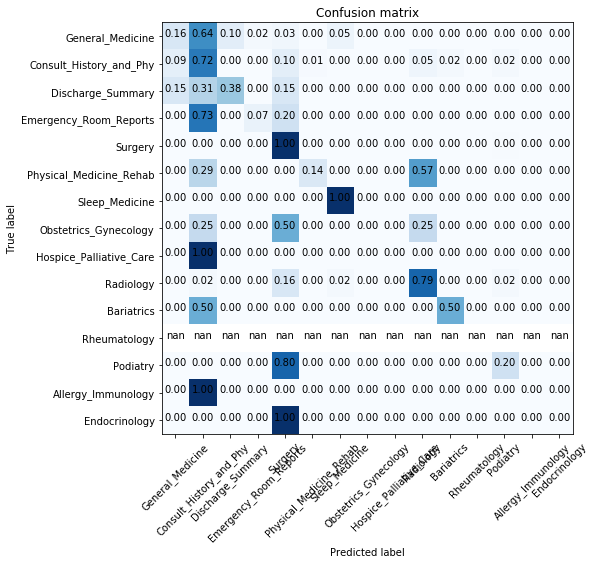

Accuracy score for MultinomialNB is 0.6620825147347741

Confusion matrix for MultinomialNB


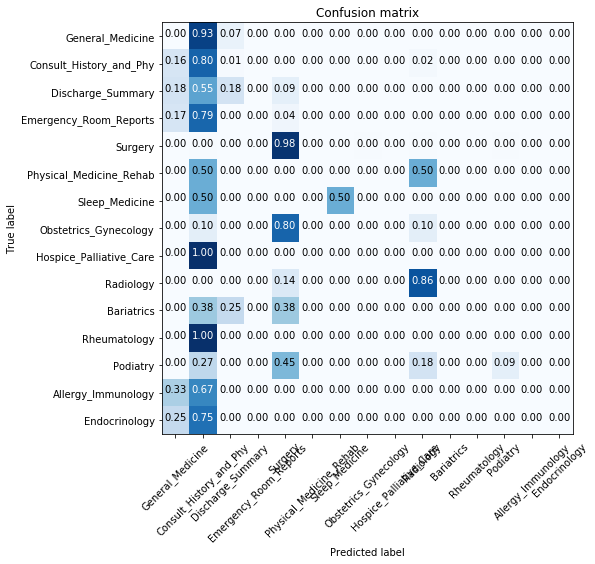

Accuracy score for SVC is 0.768172888015717

Confusion matrix for SVC


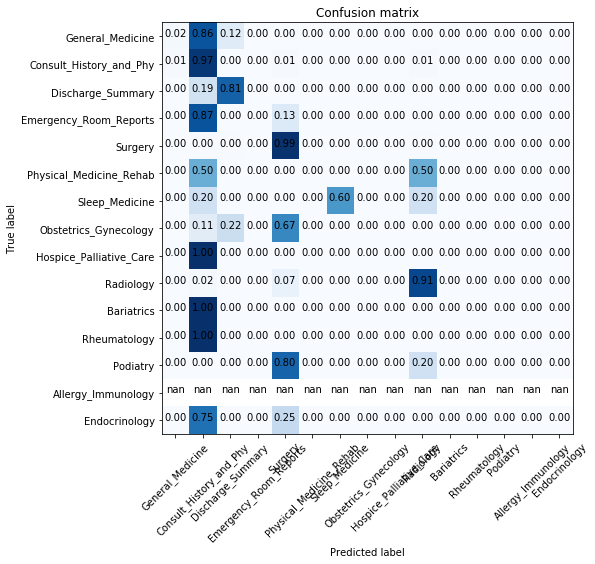

Accuracy score for SGDClassifier is 0.75049115913556

Confusion matrix for SGDClassifier


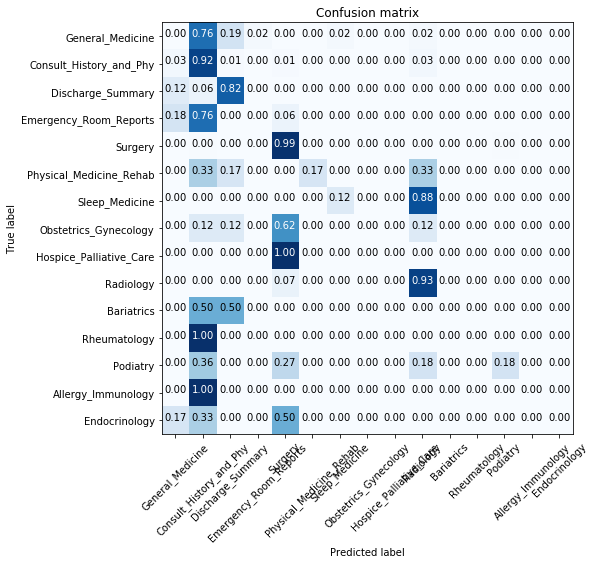

Accuracy score for RandomForestClassifier is 0.6601178781925344

Confusion matrix for RandomForestClassifier


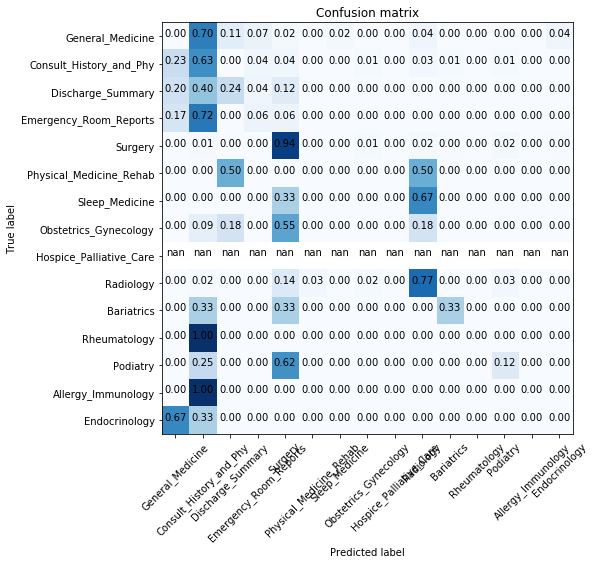

Accuracy score for GaussianNB is 0.5658153241650294

Confusion matrix for GaussianNB


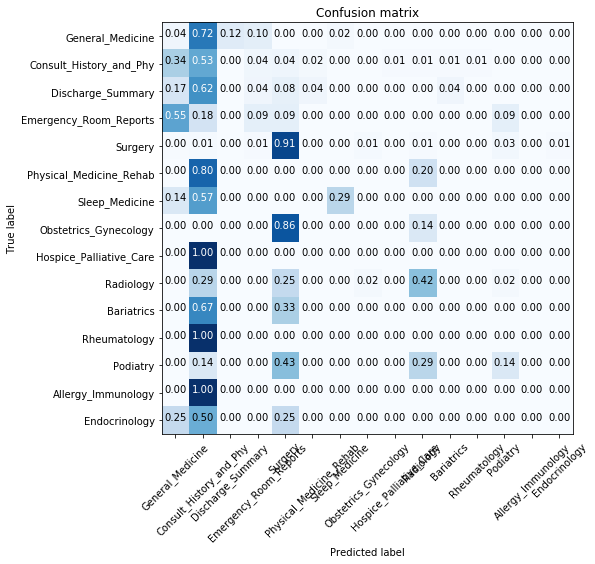

Accuracy score for AdaBoostClassifier is 0.6247544204322201

Confusion matrix for AdaBoostClassifier


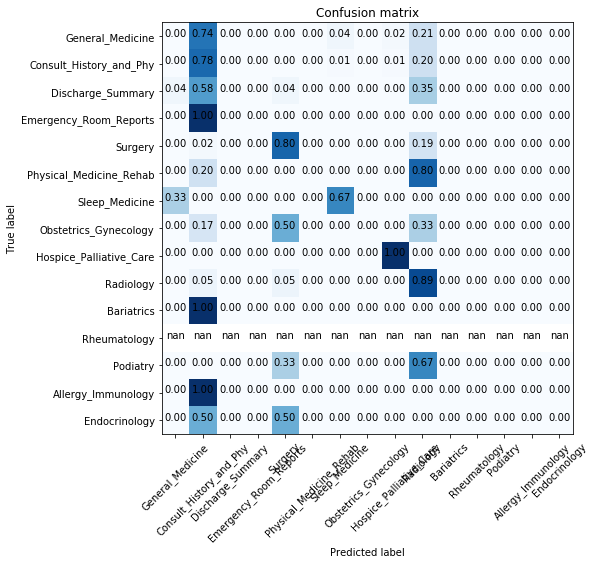

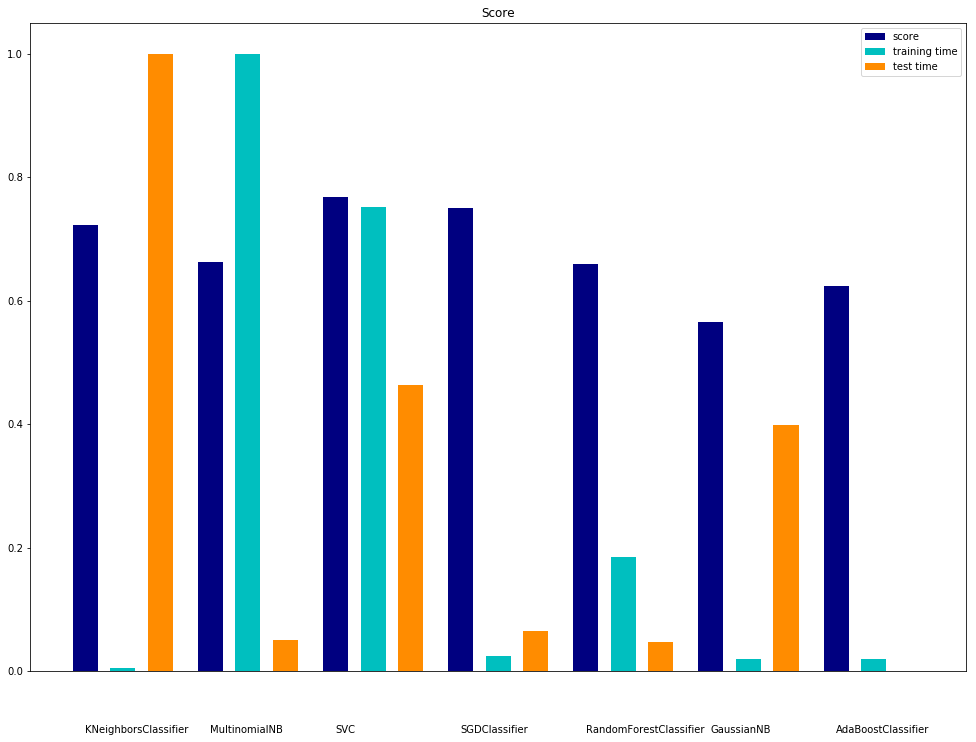

In [260]:
# Final test method to test all algorithms in one go
results = [predict_using_tfdif_svd_knn(), predit_using_multinomialNB(), predit_using_svc(), predict_using_sgd(),
           predict_using_random_forest(), predict_using_gaussianNB(), predict_using_ada_boost()]
#results = [predict_using_adaBoost()]

display_result(results=results)